# BREAST CANCER PROYECT

El objetivo de nuestro estudio se centra en discernir cuando un tumor con determinadas características se catalogará como maligno o, por lo contrario, como benigno. Para ello nos centraremos en aplicar diversos modelos de clasificación categoricas,eligiendo finalmente el modelo óptimo (mejor métrica).

En este proyecto me he querido detener en aplicar dos pasos previos de limpieza y selección de las caracteristicas dadas por nuestra base de datos para un mejor aprovechamiento de los recursos computacionales así como de una mejora de los estadísticos relativos a la multicolinealidad de variables.

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Lectura del archivo, guardado en el repositorio

In [2]:
df=pd.read_csv("mama.csv")

In [3]:
df.head()

,diagnosis,radius,texture,perimeter,smoothness,compactness,concavity,concave points,symmetry,fractal_dimension
0,M,17.99,10.38,122.80,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,M,20.57,17.77,132.90,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,M,19.69,21.25,130.00,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,M,11.42,20.38,77.58,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,M,20.29,14.34,135.10,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


## DESBALANCEO DE DATOS

En nuestro caso, observamos que las observaciones se reparten adecuadamente entre las salidas de diagnostico maligno y benigno, motivo por el cual no tendremos que aplicar técnicas de balanceo de datos para procurar que la clase minoritaria (tumor maligno) tenga más relevancia. A modo ilustrativo, en caso de producirse un desbalance podríamos aplicar:

**Ajuste de Parámetros del modelo**: Consiste en ajustar parametros ó metricas del propio algoritmo para intentar equilibrar a la clase minoritaria penalizando a la clase mayoritaria durante el entrenamiento. 

**Modificar el Dataset**: podemos eliminar muestras de la clase mayoritaria para reducirlo e intentar equilibrar la situación. Tiene como «peligroso» que podemos prescindir de muestras importantes, que brindan información y por lo tanto empeorar el modelo. 

**Muestras artificiales**: podemos intentar crear muestras sintéticas (no idénticas) utilizando diversos algoritmos que intentan seguir la tendencia del grupo minoritario. Según el método, podemos mejorar los resultados. Lo peligroso de crear muestras sintéticas es que podemos alterar la distribución «natural» de esa clase y confundir al modelo en su clasificación.

**Balanced Ensemble Methods**: Utiliza las ventajas de hacer ensamble de métodos, es decir, entrenar diversos modelos y entre todos obtener el resultado final (por ejemplo «votando») pero se asegura de tomar muestras de entrenamiento equilibradas.

In [4]:
df.pivot_table(columns="diagnosis",aggfunc="count")

diagnosis,B,M
compactness,357,212
concave points,357,212
concavity,357,212
fractal_dimension,357,212
perimeter,357,212
radius,357,212
smoothness,357,212
symmetry,357,212
texture,357,212


In [5]:
df["diagnosis"].describe()

count     569
unique      2
top         B
freq      357
Name: diagnosis, dtype: object

## VISUALIZACIONES PREVIAS 
Para entender nuestros datos y las relaciones intrínsecas

In [6]:
df.info() # observamos datos númericos de tipo float excepto nuestra varaible dependiente por lo tanto no es
# necesario implementar un ajuste de tipos 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 10 columns):
diagnosis            569 non-null object
radius               569 non-null float64
texture              569 non-null float64
perimeter            569 non-null float64
smoothness           569 non-null float64
compactness          569 non-null float64
concavity            569 non-null float64
concave points       569 non-null float64
symmetry             569 non-null float64
fractal_dimension    569 non-null float64
dtypes: float64(9), object(1)
memory usage: 44.5+ KB


In [7]:
df.describe()

,radius,texture,perimeter,smoothness,compactness,concavity,concave points,symmetry,fractal_dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798
std,3.524049,4.301036,24.298981,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060
min,6.981000,9.710000,43.790000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960
25%,11.700000,16.170000,75.170000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700
50%,13.370000,18.840000,86.240000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540
75%,15.780000,21.800000,104.100000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120
max,28.110000,39.280000,188.500000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440


In [8]:
pd.pivot_table(data=df,columns="diagnosis", aggfunc="mean")
# este pivot table nos otorga un rápido entendimiento de la revelancia de las variables para la salida a "B" o "M"

diagnosis,B,M
compactness,0.080085,0.145188
concave points,0.025717,0.087990
concavity,0.046058,0.160775
fractal_dimension,0.062867,0.062680
perimeter,78.075406,115.365377
radius,12.146524,17.462830
smoothness,0.092478,0.102898
symmetry,0.174186,0.192909
texture,17.914762,21.604906


In [9]:
corr_table = df.corr(method="pearson")# salida de correlación entre variables. Al ser condiciones físicas del tumor,
# es logico pensar que pueden estar relacionadas
corr_table

,radius,texture,perimeter,smoothness,compactness,concavity,concave points,symmetry,fractal_dimension
radius,1.000000,0.323782,0.997855,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631
texture,0.323782,1.000000,0.329533,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437
perimeter,0.997855,0.329533,1.000000,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477
smoothness,0.170581,-0.023389,0.207278,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792
compactness,0.506124,0.236702,0.556936,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369
concavity,0.676764,0.302418,0.716136,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783
concave points,0.822529,0.293464,0.850977,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917
symmetry,0.147741,0.071401,0.183027,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921
fractal_dimension,-0.311631,-0.076437,-0.261477,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000


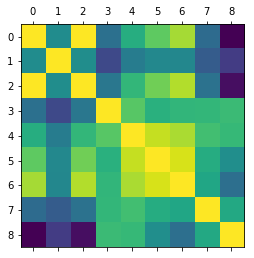

In [10]:
plt.matshow(corr_table)

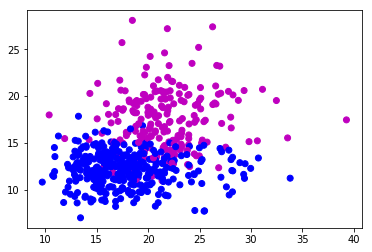

In [11]:
plt.scatter(df["texture"],df["radius"],c=df["diagnosis"]); #ejemplo de la relación de la variable dependiente 
#respecto a la textura y el radio

# PREPARACIÓN DEL DATASET

## 1) target dummies

In [12]:
diagnosis_dummy = {'B': 0, 'M': 1}
df['diagnosis'].replace(diagnosis_dummy, inplace=True)

 ## 2) Removido de variables correlacionadas
 
 Antes de decidir si aplicar el método de **Recursive Features Elimination** (aplicado mediante cross validation para optimizar el resultado) hago un paso previo para eliminar las caracterísitcas que presentan alta correlación ya que, como vimos en la parte "Visualizaciones previas", las características guardan una importante relación. Esto no es bueno para nuestro modelo ya que, aparte de no aportarnos información interesante, el modelo puede no ser estadísticamente contundente hasta llegar a capar las posibilidades de inversión de matrices de una regresión (determinante=0) si esta correlación  es 1 (algo muy dificil de suceder no obstante)
 
En este proyecto he preferido rebajar la dimensión con este nuevo algoritmo, en vez de por **PCA** ya que me interesaba reducir las variables existentes en vez de obtener una salida más abstracta que PCA (la cual, agrandes rasgos, saca los pesos de las componentes en función del valor de los autovalores/autovecores de la matriz de covarianzas). 

Otra posibilidad que no he querido desarrollar esta vez, aunque podría resultar bastante acertada, es aplicar **Lasso** con la funcionalidad de reducción de la dimensionalidad (no solamente para para su función principal que es rebajar el overfitting)

In [13]:
df

,diagnosis,radius,texture,perimeter,smoothness,compactness,concavity,concave points,symmetry,fractal_dimension
0,1,17.990,10.38,122.80,0.11840,0.27760,0.300100,0.147100,0.2419,0.07871
1,1,20.570,17.77,132.90,0.08474,0.07864,0.086900,0.070170,0.1812,0.05667
2,1,19.690,21.25,130.00,0.10960,0.15990,0.197400,0.127900,0.2069,0.05999
3,1,11.420,20.38,77.58,0.14250,0.28390,0.241400,0.105200,0.2597,0.09744
4,1,20.290,14.34,135.10,0.10030,0.13280,0.198000,0.104300,0.1809,0.05883
5,1,12.450,15.70,82.57,0.12780,0.17000,0.157800,0.080890,0.2087,0.07613
6,1,18.250,19.98,119.60,0.09463,0.10900,0.112700,0.074000,0.1794,0.05742
7,1,13.710,20.83,90.20,0.11890,0.16450,0.093660,0.059850,0.2196,0.07451
8,1,13.000,21.82,87.50,0.12730,0.19320,0.185900,0.093530,0.2350,0.07389
9,1,12.460,24.04,83.97,0.11860,0.23960,0.227300,0.085430,0.2030,0.08243


In [14]:
correlated_features = set()
correlation_matrix = df.drop('diagnosis', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [15]:
correlated_features = list(correlated_features)
correlated_features

['concave points', 'concavity', 'perimeter']

### VARIABLES

In [16]:
y = df["diagnosis"]


In [17]:
X = df.drop(columns="diagnosis",axis=1, inplace=True)
X = df.drop(columns=correlated_features)
X

,radius,texture,smoothness,compactness,symmetry,fractal_dimension
0,17.990,10.38,0.11840,0.27760,0.2419,0.07871
1,20.570,17.77,0.08474,0.07864,0.1812,0.05667
2,19.690,21.25,0.10960,0.15990,0.2069,0.05999
3,11.420,20.38,0.14250,0.28390,0.2597,0.09744
4,20.290,14.34,0.10030,0.13280,0.1809,0.05883
5,12.450,15.70,0.12780,0.17000,0.2087,0.07613
6,18.250,19.98,0.09463,0.10900,0.1794,0.05742
7,13.710,20.83,0.11890,0.16450,0.2196,0.07451
8,13.000,21.82,0.12730,0.19320,0.2350,0.07389
9,12.460,24.04,0.11860,0.23960,0.2030,0.08243


In [18]:
X_columns = X.columns
X_columns

Index(['radius', 'texture', 'smoothness', 'compactness', 'symmetry',
       'fractal_dimension'],
      dtype='object')

## 3) Escalado

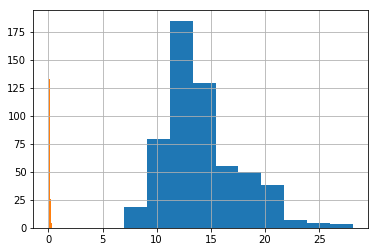

In [19]:
X.radius.hist();X.compactness.hist() # ejemplo de observancia de diferentes magnitudes de nuestras variables

In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
X = pd.DataFrame(scaled_X, columns=X_columns)
X

,radius,texture,smoothness,compactness,symmetry,fractal_dimension
0,0.521037,0.022658,0.593753,0.792037,0.686364,0.605518
1,0.643144,0.272574,0.289880,0.181768,0.379798,0.141323
2,0.601496,0.390260,0.514309,0.431017,0.509596,0.211247
3,0.210090,0.360839,0.811321,0.811361,0.776263,1.000000
4,0.629893,0.156578,0.430351,0.347893,0.378283,0.186816
5,0.258839,0.202570,0.678613,0.461996,0.518687,0.551179
6,0.533343,0.347311,0.379164,0.274891,0.370707,0.157119
7,0.318472,0.376057,0.598267,0.445126,0.573737,0.517060
8,0.284869,0.409537,0.674099,0.533157,0.651515,0.504002
9,0.259312,0.484613,0.595558,0.675480,0.489899,0.683867


##  3) Running RFECV (recursive features estimator-cross validation)
Ahora que ya tenemos los conjuntos de variables **X** e **y**, podemos aplicar RFECV. Para ello, en este caso usaré RandomForest como algoritmo como la instancia en la que sustentar este método de preprocesado de datos. Ahora podemos crear la instancia de RFECV, en la cual se necesitan los siguientes argumentos:

**estimator** — model instance

**step** — número de variables a eliminar en cada iteración

**cv** — Cross-Validation, usando StratifiedKFold y fijando K = 10

**scoring** — scoring metric, lo que queremos optimizar. En este caso escojo "accuracy" pero podríamos escoger otros

La RFE nos permite seleccionar las variables (características) independientes que servirán para estructurar el modelo y dar respuesta a la pregunta inicial que es predecir el cancer de mama, considerando estas características. 

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [23]:
rfc = RandomForestClassifier(random_state=101)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=101, verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

Cuantas caracteristicas son optimas para lograr el mejor accuracy:

In [24]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 4


Podemos plotear el accuracy obtenido por cada nº de variables tenidas en cuenta

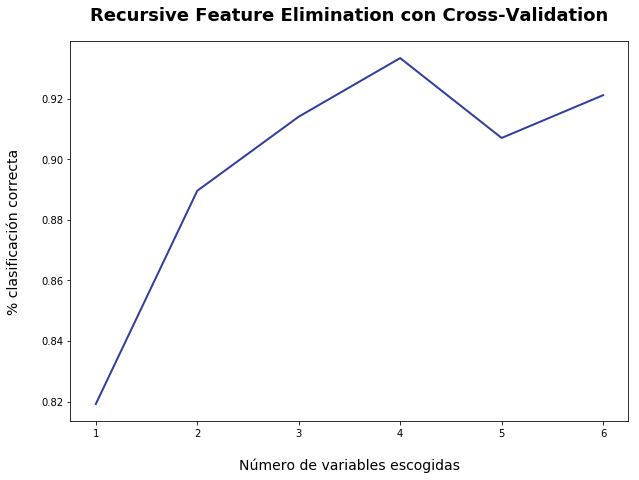

In [25]:
plt.figure(figsize=(10, 7))
plt.title('Recursive Feature Elimination con Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Número de variables escogidas', fontsize=14, labelpad=20)
plt.ylabel('% clasificación correcta', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=2)

plt.show()

In [26]:
print(np.where(rfecv.support_ == False)[0])

X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[4 5]


In [27]:
rfecv.support_

array([ True,  True,  True,  True, False, False])

Es visible que con 4 variables tenemos el mejor accuracy

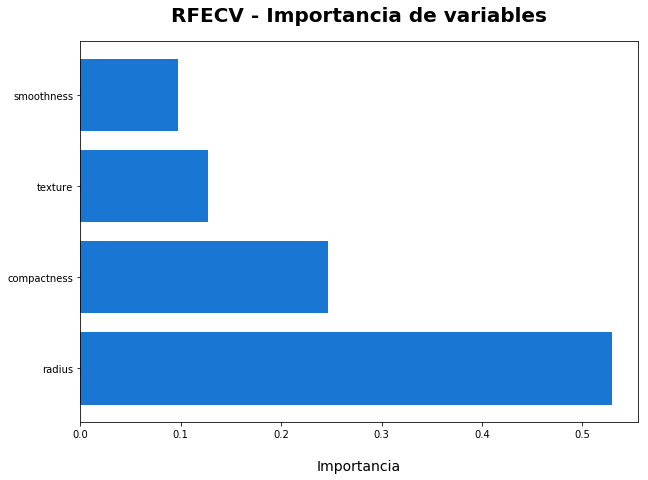

In [28]:
dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importancia'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importancia', ascending=False)

plt.figure(figsize=(10, 7))
plt.barh(y=dset['attr'], width=dset['importancia'], color='#1976D2')
plt.title('RFECV - Importancia de variables', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importancia', fontsize=14, labelpad=20)
plt.show()

### RESUMEN

En estos momentos del proyecto nos encontramos con nuestro dataset preparado para ser modelado, donde podemos apreciar la relevancia de las distintas caracteristicas del tumor, siendo el radio la caracteristica con mayor peso en la categoría que queremos clasificar (maligno o benigno)

# MODELADO 

#### METODOLOGÍA
Selección de características

Luego de explorar en general los datos y quedarnos con las variables independientes que más valor nos aportará, es momento de crear los diferentes modelos que hemos elegido como más útiles para el próposito de clasificación binaria (de nuestra variable categórica "M") para quedarnos con el que mejor métrica nos aporte. Estos serán los siguientes algoritmos de modelización:

- Regresión Logistica
- K-vecinos
- SCV (support vector machine)
- Árboles de decisión

#### MÉTRICAS USADAS
Para ello nos vamos a centrar en este caso en un tipo de métrica muy común en análisis médicos. Se trata de la métrica **auc** la cual se relaciona con el área bajo la curva ROC ("Característica de funcionamiento del receptor"), comprendida entre 0.5 y 1.

En la curva de  (Curva ROC) la línea de puntos en rojo representa un clasificador basado solamente en el azar (como si se lanzara una moneda para predecir un resultado). Un buen clasificador debería estar sobre esta línea (hacia el extremo superior izquierdo). 

El modelo tiene que ser lo suficientemente consistente para salvaguardar el equilibrio entre el ruido y la diferenciancion de varianzas de las muestras seleccionadas

**Métrica óptima (Recall)**: con la matriz de confusión podemos observar la relación de sensibilidad y especificidad del modelo. Atendiendo a nuestro propósito del proyecto (clasificar cuando es maligno un tumor) necesitamos darle mayor peso a que los tumores que se predigan como benignos, siendo realmente malignos, sean los menores (es decir, obtener la menor cantidad de falsos negativos). Esto lo tendremos en cuenta en la decisión final del modelo con la salida de **Recall**. 

#### CONCEPTOS BÁSICOS
Una buena práctica en Machine Learning es la de subdividir nuestro conjunto de datos de entrada en un set de entrenamiento y otro para validar el modelo (que no se utiliza durante el entrenamiento y por lo tanto la máquina desconoce). Esto evitará problemas en los que nuestro algoritmo pueda fallar por «sobregeneralizar» el conocimiento. 

Por otro lado, la programación en este lenguaje python nos proporciona algoritmos ya creados que nos facilitará iterar por los distintos parámetros e hiperparámetros de los diferentes algoritmos y así encontrar el más indicado. Esto lo conseguiremos con el método de selección **GridSearch**. 

A continuación importaré las librerías necesarias e implementaré una función de visualización de la curva ROC

In [29]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve,auc,roc_auc_score
import seaborn as sns

In [30]:
#sacamos gráfica de la curva roc
def roc_plot(fp,tp,auc):
        plt.figure()
        plt.plot(fp, tp, label='Regresión Logística (área = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
        plt.title('Característica de funcionamiento del receptor (Curva ROC)')
        plt.legend(loc="lower right")
        plt.savefig('Log_ROC')
        plt.show()

## LOGISTIC REGRESSION CLASIFIER

In [31]:
from sklearn.linear_model import LogisticRegression

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [33]:
# Grid search cross validation
reg=GridSearchCV(LogisticRegression(),
                param_grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]},# l1 lasso l2 ridge
                 cv=10,
                 scoring="recall"
                )

In [34]:
reg.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [35]:
print(reg.best_params_)
print("the best score is %f" %(reg.best_score_))

{'C': 100.0, 'penalty': 'l1'}
the best score is 0.887171


In [36]:
clf = reg.best_estimator_

### *MÉTRICAS* 

In [37]:
y_pred = clf.predict(X_test)
print('Precisión del clasificador: {:.2f}'.format(clf.score(X_test, y_test)))
score_clf = clf.score(X_test, y_test)

Precisión del clasificador: 0.96


In [38]:
print(classification_report(y_test,y_pred))#fl_score es la medida armónica

             precision    recall  f1-score   support

          0       0.97      0.97      0.97        40
          1       0.94      0.94      0.94        17

avg / total       0.96      0.96      0.96        57



In [39]:
confusion_matrix(y_test,y_pred)

array([[39,  1],
       [ 1, 16]], dtype=int64)

Veamos la comparativa de esta confussion matrix creando un dataframe al efecto

In [40]:
comparativa = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})


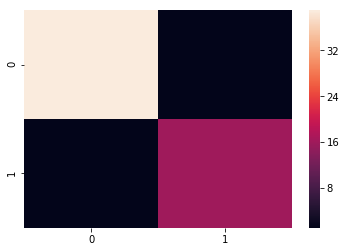

In [41]:
sns.heatmap(confusion_matrix(y_test,y_pred))

#### ROC CURVE

In [42]:
pred=clf.predict_proba(X_test)

In [43]:
target_pos = 1 # Or 0 for the other class
fp,tp,_ = roc_curve(y_test,pred[:,target_pos])

In [44]:
auc_metric_logreg = auc(fp,tp)

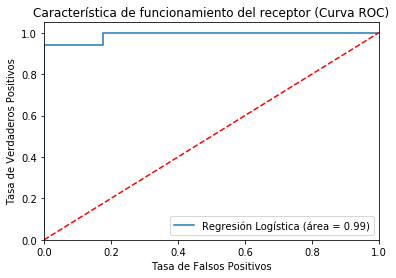

In [45]:
roc_plot(fp,tp,auc_metric_logreg)

## K NEAREST NEIGHBORS CLASSIFIER

In [46]:
from sklearn.neighbors import KNeighborsClassifier

In [47]:
reg=GridSearchCV(KNeighborsClassifier(),
                param_grid={"n_neighbors":np.arange(4,100)},
                 cv=10,
                 scoring="recall"
                )

In [48]:
reg.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 4,  5, ..., 98, 99])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [49]:
print(reg.best_params_)
print("the best score is %f" %(reg.best_score_))

{'n_neighbors': 19}
the best score is 0.897451


In [50]:
clkn = reg.best_estimator_

### MÉTRICAS

In [51]:
y_pred = clkn.predict(X_test)
print('Precisión del clasificador: {:.2f}'.format(reg.score(X_test, y_test)))
score_clkn = clkn.score(X_test, y_test)

Precisión del clasificador: 0.94


In [52]:
print(classification_report(y_test,y_pred))#fl_score es la medida armónica

             precision    recall  f1-score   support

          0       0.97      0.95      0.96        40
          1       0.89      0.94      0.91        17

avg / total       0.95      0.95      0.95        57



In [53]:
confusion_matrix(y_test,y_pred)

array([[38,  2],
       [ 1, 16]], dtype=int64)

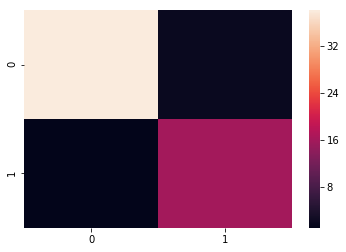

In [54]:
sns.heatmap(confusion_matrix(y_test,y_pred))

#### ROC CURVE

In [55]:
pred=clkn.predict_proba(X_test)

In [56]:
target_pos = 1 # Or 0 for the other class
fp,tp,_ = roc_curve(y_test,pred[:,target_pos])

In [57]:
auc_metric_kn = auc(fp,tp)

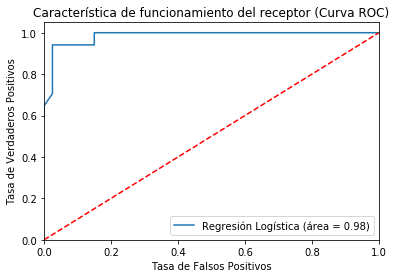

In [58]:
roc_plot(fp,tp,auc_metric_kn)

## SUPPORT VECTOR CLASSIFIER

In [59]:
from sklearn.svm import SVC

In [60]:
reg = GridSearchCV(SVC(kernel="poly",probability=True),
                  param_grid={"C":[1,5,50], "degree":[2,3]},
                  cv=5,
                  scoring="recall")

In [61]:
reg.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1, 5, 50], 'degree': [2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [62]:
print(reg.best_params_)
print("the best score is %f" %(reg.best_score_))

{'C': 50, 'degree': 2}
the best score is 0.856470


In [63]:
clsv = reg.best_estimator_

### METRICAS

In [64]:
y_pred = clsv.predict(X_test)
print('Precisión del clasificador: {:.2f}'.format(clsv.score(X_test, y_test)))
score_clsv = clsv.score(X_test, y_test)

Precisión del clasificador: 0.95


In [65]:
print(classification_report(y_test,y_pred))#fl_score es la medida armónica

             precision    recall  f1-score   support

          0       0.95      0.97      0.96        40
          1       0.94      0.88      0.91        17

avg / total       0.95      0.95      0.95        57



In [66]:
confusion_matrix(y_test,y_pred)

array([[39,  1],
       [ 2, 15]], dtype=int64)

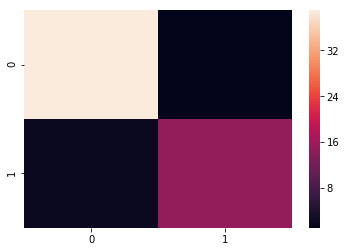

In [67]:
sns.heatmap(confusion_matrix(y_test,y_pred))

#### ROC CURVE

In [68]:
pred=clsv.predict_proba(X_test)

In [69]:
target_pos = 1 # Or 0 for the other class
fp,tp,_ = roc_curve(y_test,pred[:,target_pos])

In [70]:
auc_metric_sv = auc(fp,tp)

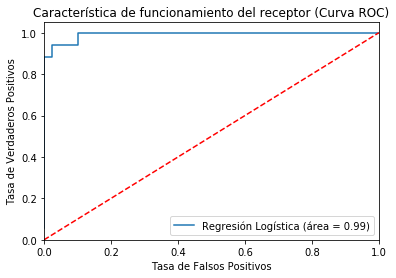

In [71]:
roc_plot(fp,tp,auc_metric_sv)

## DECISION TREE CLASSIFIER

In [72]:
from sklearn.tree import DecisionTreeClassifier

In [73]:
reg = GridSearchCV(DecisionTreeClassifier(),
                  param_grid={"max_depth":np.arange(2,20), 
                              "min_samples_leaf":np.arange(20,100,20)},
                  cv=10,
                  scoring="recall")

In [74]:
reg.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]), 'min_samples_leaf': array([20, 40, 60, 80])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [75]:
print(reg.best_params_)
print("the best score is %f" %(reg.best_score_))

{'max_depth': 3, 'min_samples_leaf': 20}
the best score is 0.836266


In [76]:
cldt = reg.best_estimator_

### METRICAS

In [77]:
y_pred = cldt.predict(X_test)
print('Precisión del clasificador: {:.2f}'.format(cldt.score(X_test, y_test)))
score_cldt = cldt.score(X_test, y_test)

Precisión del clasificador: 0.96


In [78]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.97      0.97      0.97        40
          1       0.94      0.94      0.94        17

avg / total       0.96      0.96      0.96        57



In [79]:
confusion_matrix(y_test,y_pred)

array([[39,  1],
       [ 1, 16]], dtype=int64)

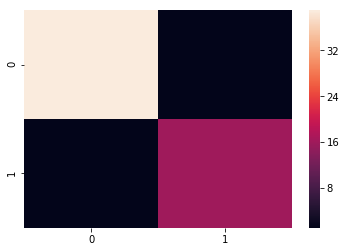

In [80]:
sns.heatmap(confusion_matrix(y_test,y_pred))

#### ROC CURVE

In [81]:
pred=cldt.predict_proba(X_test)

In [82]:
# We chose the target
target_pos = 1 # Or 0 for the other class
fp,tp,_ = roc_curve(y_test,pred[:,target_pos])

In [83]:
auc_metric_dt = auc(fp,tp)

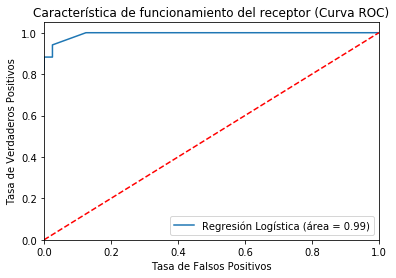

In [84]:
roc_plot(fp,tp,auc_metric_dt)

# SELECCIÓN

In [85]:
list_auc = [auc_metric_logreg,auc_metric_kn,auc_metric_sv,auc_metric_dt]
list_score = [score_clf,score_clkn,score_clsv,score_cldt]
list_models = ["logreg","Kneighbors","svm","decision_tree"]

df_metric = pd.DataFrame({"model": list_models, "auc": list_auc, 'score': list_score})


In [86]:
df_metric

,model,auc,score
0,logreg,0.989706,0.964912
1,Kneighbors,0.984559,0.947368
2,svm,0.992647,0.947368
3,decision_tree,0.994118,0.964912


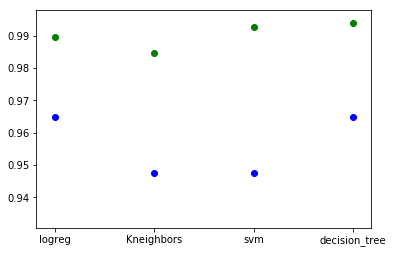

In [87]:
plt.figure()
plt.scatter(list_models,list_score,c="blue")
plt.scatter(list_models,list_auc,c="green")
plt.show()

In [88]:
df_metric.max

<bound method DataFrame.max of            model       auc     score
0         logreg  0.989706  0.964912
1     Kneighbors  0.984559  0.947368
2            svm  0.992647  0.947368
3  decision_tree  0.994118  0.964912>

Realizando la comparativa de las diferentes métricas observamos que el algoritmo de árboles de decisión obtiene la mejor puntuación. Es el modelo más completo y que mayor área bajo la curva ROC tiene, ya que además presenta junto con el modelo de regresión logisica el mayor score (que en nuestro caso nos interesaba Recall)

Por ello sería este modelo el que poner en producción para el analisis de los tumores de mama

### CONCLUSIÓN

Con este sencillo ejercicio hemos podido comprobar el potencial de los algoritmos de clasificación y su puesta en escena en un sector tan sumamente importante como es la medicina. 

Aspectos a mejorar serían la posibilidad de acentrarnos más exaustivamente en cada modelo (remodelar) para intentar rascar unas décimas a las métricas 